In [173]:
# Libraries
# Importing necessary libraries for ANN implementation through Pytorch
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Reading in the NY taxi fare dataset.

In [174]:
# This is the limited dataset to run full ANN on this data.
df = pd.read_csv("../Data/NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


# The idea is to build a model to predict the fare_amount for a trip. It is a regression problem.

# Do some exploratory data analysis.

In [175]:
# What is the range of the target

In [176]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

In [177]:
df['pickup_longitude'].describe()

count    120000.000000
mean        -73.976626
std           0.031497
min         -74.465447
25%         -73.992386
50%         -73.982084
75%         -73.968710
max         -73.311845
Name: pickup_longitude, dtype: float64

In [178]:
# The dataset is fairly simple, so we have to do some feature engineering to pass features to the model.
#  pickup_longitude and  pickup_longitude wouldn't make sense to be included as it is.
    # because if you see the data, trip would be in the vicinity where pickup and dropoff location wouldn't change much.
    # This is evident in the std of the describe() of the pickup_longitude column, std = 0.03


# Information about the dataframe

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


# pickup datetime column 

In [180]:
# Converting this pickup_datetime to datetime column
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [181]:
print(f"Min Date in this dataframe: {df['pickup_datetime'].min()}")
print(f"Min Date in this dataframe: {df['pickup_datetime'].max()}")

Min Date in this dataframe: 2010-04-11 04:00:10+00:00
Min Date in this dataframe: 2010-04-25 03:59:42+00:00


Because the time is in UTC and NY time is 4 hours behind UTC,  we need to subtract 4 hours from it and then do any kind of EDA on hours

In [182]:
df['EDT_pickup_datetime'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['EDT_pickup_datetime'].dt.hour.value_counts()

EDT_pickup_datetime
15    7100
14    6972
16    6731
17    6487
18    6358
13    5994
10    5928
11    5849
9     5766
8     5730
4     5655
19    5652
5     5649
7     5420
6     5349
12    5136
3     4665
20    4664
21    3573
22    2893
2     2855
23    2237
0     1768
1     1569
Name: count, dtype: int64

# the highest pickups are happening in the afternoon at 3pm followed by 2pm, 4pm etc.

# Feature Engineering

In [183]:
# Couple of Feature Engineering ideas to build features from this dataset
# 1) hour of the day when pickup happened
# 2) am/pm time of the day
# 3_ day of the week
# 4) some kind of distance between latitude and longitude.


In [184]:
# We will use haversine to calculate spherical distance between  GPS coordinates.
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

# New Features

In [185]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df['hour_of_day'] = df['EDT_pickup_datetime'].dt.hour

df['am_or_pm'] = np.where(df['hour_of_day'] > 12, 'pm', 'am')

# For day of the week
df['day_of_week'] = df['EDT_pickup_datetime'].dt.strftime('%a')
df['weekday_or_weekend'] = np.where(df['day_of_week'].isin(['Sat','Sun']), 'weekend', 'weekday')
df.head()


,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,EDT_pickup_datetime,dist_km,hour_of_day,am_or_pm,day_of_week,weekday_or_weekend
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010-04-19 04:17:56+00:00,2.126312,4,am,Mon,weekday
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010-04-17 11:43:53+00:00,1.392307,11,am,Sat,weekend
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010-04-17 07:23:26+00:00,3.326763,7,am,Sat,weekend
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010-04-11 17:25:03+00:00,1.864129,17,pm,Sun,weekend
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010-04-16 22:19:01+00:00,7.231321,22,pm,Fri,weekday


In [186]:
df['day_of_week'].value_counts()

day_of_week
Fri    19720
Thu    18539
Sat    18355
Wed    17360
Tue    17189
Mon    15509
Sun    13328
Name: count, dtype: int64

# Separating into categorical, continuous and target

In [187]:
cat_cols = ['hour_of_day', 'am_or_pm', 'weekday_or_weekend']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']
y_col = ['fare_amount']

Converting categorical columns as categories. 

In [188]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

# Recognizes cat_cols as categories.

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   pickup_datetime      120000 non-null  datetime64[ns, UTC]
 1   fare_amount          120000 non-null  float64            
 2   fare_class           120000 non-null  int64              
 3   pickup_longitude     120000 non-null  float64            
 4   pickup_latitude      120000 non-null  float64            
 5   dropoff_longitude    120000 non-null  float64            
 6   dropoff_latitude     120000 non-null  float64            
 7   passenger_count      120000 non-null  int64              
 8   EDT_pickup_datetime  120000 non-null  datetime64[ns, UTC]
 9   dist_km              120000 non-null  float64            
 10  hour_of_day          120000 non-null  category           
 11  am_or_pm             120000 non-null  category           
 12  da

In [190]:
df['hour_of_day'].head()

0     4
1    11
2     7
3    17
4    22
Name: hour_of_day, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [191]:
# Stacking categorical columns codes into array of values and converting it tensors.
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64)
cats

tensor([[ 4,  0,  0],
        [11,  0,  1],
        [ 7,  0,  1],
        ...,
        [14,  1,  1],
        [ 4,  0,  0],
        [12,  0,  1]])

In [192]:
conts = np.stack([df[cont].values for cont in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [193]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

# Embedding Layer of pytorch for categorical columns, In simplicity it is just like one-hot encoding

In [194]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 2]

In [195]:
# Embedding sizes based of the categories. The embedding size for each category is give by the general rule of thumb is by 
# dividing the size by 2 maxed at 50.
emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (2, 1)]

# Tabular Model

In [196]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist=[]
        n_embs = sum([nf for ni,nf in emb_sizes])
        n_in = n_embs + n_cont

        # eg layers input [200,100,50[
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace = True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)
     
        
    def forward(self, x_cat, x_cont):
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont],1)
        x = self.layers(x)
        return x

In [197]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1, [200,100], p=0.4)

In [198]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1-2): 2 x Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Loss Criteria and optimizer

In [199]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [200]:
# We feed in with two batches of batch_size = 60k

In [201]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [202]:
# Data Shuffled Already
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

#Target
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [203]:
import time
start_time=time.time()
epochs = 300

losses = []
for i in range(epochs):
    y_pred = model(cat_train, cont_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) #RMSE

    losses.append(loss)
    if i%10==1:
        print(f"epoch : {i} loss is {loss}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


dur = time.time() - start_time
print(f'Training time {dur/60} mins')


epoch : 1 loss is 12.320149421691895
epoch : 11 loss is 11.38512897491455
epoch : 21 loss is 10.86568832397461
epoch : 31 loss is 10.525838851928711
epoch : 41 loss is 10.29439640045166
epoch : 51 loss is 10.127175331115723
epoch : 61 loss is 9.968570709228516
epoch : 71 loss is 9.812289237976074
epoch : 81 loss is 9.638513565063477
epoch : 91 loss is 9.451355934143066
epoch : 101 loss is 9.209268569946289
epoch : 111 loss is 8.967071533203125
epoch : 121 loss is 8.65581226348877
epoch : 131 loss is 8.311509132385254
epoch : 141 loss is 7.9370903968811035
epoch : 151 loss is 7.501902103424072
epoch : 161 loss is 7.040217399597168
epoch : 171 loss is 6.558457851409912
epoch : 181 loss is 6.075490474700928
epoch : 191 loss is 5.573940753936768
epoch : 201 loss is 5.110750198364258
epoch : 211 loss is 4.701475620269775
epoch : 221 loss is 4.344478607177734
epoch : 231 loss is 4.111380100250244
epoch : 241 loss is 3.9368112087249756
epoch : 251 loss is 3.8321385383605957
epoch : 261 loss i

# Plots the losses on the epoch 

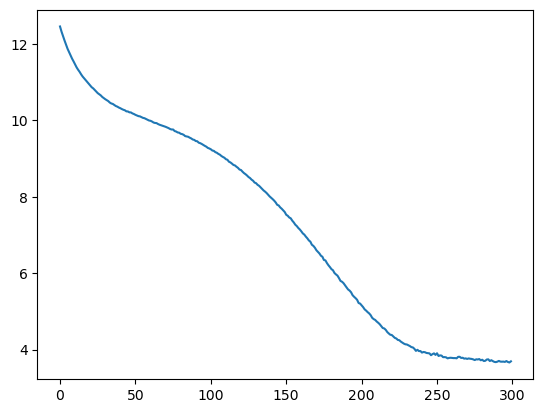

In [204]:
# Extracting numerical values from tensors
loss_values = [loss.item() for loss in losses]

plt.plot(range(epochs), loss_values)

# Evaluate on the test set

In [205]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
    

In [206]:
loss

tensor(3.6847)

# The loss on the test set is lower than the training loss. Need to check if there were more epochs, the training loss could have gone down but it looks 
# that it would have converged around 3.7

# How predicted and actual look on first 10 test data points.

In [207]:
for i in range(10):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f'{i}.) PREDICTED :{y_val[i].item():8.2f} TRUE :{y_test[i].item():8.2f}, diff : {diff:8.2f}') 

0.) PREDICTED :    4.53 TRUE :    2.90, diff :     1.63
1.) PREDICTED :   22.86 TRUE :    5.70, diff :    17.16
2.) PREDICTED :    6.80 TRUE :    7.70, diff :     0.90
3.) PREDICTED :   13.12 TRUE :   12.50, diff :     0.62
4.) PREDICTED :    4.36 TRUE :    4.10, diff :     0.26
5.) PREDICTED :    5.45 TRUE :    5.30, diff :     0.15
6.) PREDICTED :    8.23 TRUE :    3.70, diff :     4.53
7.) PREDICTED :   20.66 TRUE :   14.50, diff :     6.16
8.) PREDICTED :    3.33 TRUE :    5.70, diff :     2.37
9.) PREDICTED :   13.59 TRUE :   10.10, diff :     3.49


In [208]:
# Save this model
torch.save(model.state_dict, 'nyc_taxi_model.pt')